In [100]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [101]:
#!pip install tensorflow

In [102]:
df = pd.read_csv('train_data_cleaning.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this # earthquake...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask . Canada,1
2,5,NaN,NaN,All residents asked to ' shelter in place ' ...,1
3,6,NaN,NaN,"13,000 people receive # wildfires evacuation ...",1
4,7,NaN,NaN,Just got sent this photo from Ruby # Alaska a...,1


In [103]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


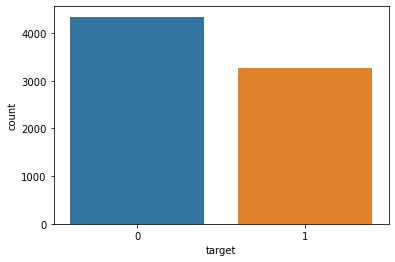

In [104]:
sns.countplot(df['target']);

In [105]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [106]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [107]:
df.shape

(7613, 5)

In [108]:
# we will drop id as it is unique
df = df.drop('id',axis=1)

In [109]:
df.isnull().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [110]:
# we will drop the keyword and location as well
df = df.drop(['keyword','location'],axis=1)

In [111]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [112]:
df.text = df.text.apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))

# Convert text to lowercase
df.text = df.text.apply(lambda x: x.lower())

# Strip unwanted spaces
df.text = df.text.apply(lambda x: x.strip())

In [113]:
def clean_text(text):
    text = text.lower()                                  # lower-case all characters
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return text

In [114]:
df['clean_text'] = df['text'].apply(clean_text)

In [115]:
df.head()

,text,target,clean_text
0,our deeds are the reason of this earthquake ma...,1,deeds reason earthquake may allah forgive
1,forest fire near la ronge sask canada,1,forest fire near ronge sask canada
2,all residents asked to shelter in place are be...,1,residents asked shelter place notified officer...
3,people receive wildfires evacuation orders in ...,1,people receive wildfires evacuation orders cal...
4,just got sent this photo from ruby alaska as s...,1,got sent photo ruby alaska smoke wildfires pou...


In [116]:
t_1 = df[df['target']==1]['clean_text']
t_0 = df[df['target']==0]['clean_text']

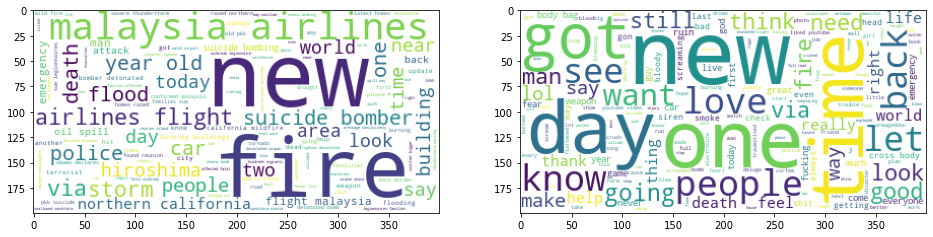

In [117]:
w_1 = WordCloud(background_color='white',max_font_size=88).generate(" ".join(t_1))
w_0 = WordCloud(background_color='white',max_font_size=88).generate(" ".join(t_0))
plt.figure(1,figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(w_1);
plt.subplot(1,2,2)
plt.imshow(w_0);

In [118]:
x = df['clean_text']
y = df['target']

In [119]:
x_train,x_test,y_train,y_test  = train_test_split(x,y,test_size=0.3,random_state=1)

In [120]:
count_vector = CountVectorizer()
train_counts = count_vector.fit_transform(x_train)

In [121]:
train_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [125]:
tfidf_vector = TfidfVectorizer(stop_words=stopwords)
tfidf_train = tfidf_vector.fit_transform(x_train)
tfidf_test = tfidf_vector.transform(x_test)

In [126]:
tfidf_nb = MultinomialNB()
tfidf_nb_model = tfidf_nb.fit(tfidf_train,y_train)

In [127]:
tfidf_nb_pred = tfidf_nb_model.predict(tfidf_test)

In [128]:
from sklearn.metrics import accuracy_score,classification_report

In [129]:
accuracy_score(y_test,tfidf_nb_pred)

0.8012259194395797

In [130]:
print(classification_report(y_test,tfidf_nb_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1326
           1       0.83      0.66      0.74       958

    accuracy                           0.80      2284
   macro avg       0.81      0.78      0.79      2284
weighted avg       0.81      0.80      0.80      2284



In [154]:
features = tfidf_vector.get_feature_names()
sum1 = tfidf_train.sum(axis=0)
data = []
for i, j in enumerate(features):
    data.append((j,sum1[0,i]))
ranking = pd.DataFrame(data, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False))

        term       rank
6380    like  47.953253
4076    fire  37.908752
4496     get  35.980008
7516    news  34.347619
7505     new  32.639662
...      ...        ...
8602  prints   0.218050
6594    lulu   0.218050
1589  cafire   0.214216
8972   recip   0.212190
5324     ika   0.212190

[12558 rows x 2 columns]
